# Multivariate linear regression: Predicting the AQI (air quality index) using weather and pollution data for Aoti Zhongxin station - Beijing.

## Introduction
[This data set](https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data)$^2$ includes air pollutant data from the Aoti Zhongxin station (Beijing) taken from the Beijing Municipal Environmental Monitoring Center. Variables in this dataset include: time, measured concentrations of various pollutants, temperature, pressure, dew point, precipitation and wind information. The time period is: March 1st, 2013 - February 28th, 2017.
AQI is a measurement for air quality that indicates how polluted the air currently is. It is calculated using the individual AQI levels of O3, PM2.5, PM10, CO, SO2 and NO2, which can be calculated from pollutant concentrations.  
We will use a multivariate linear regression model to answer the question "How do the chosen weather variables affect AQI in Beijing?". The variables used in the model are dew point, air pressure, and wind speed - which are selected from the full dataset following exploratory data analysis.

## Methods & Results

In [1]:
# Load libraries, run before everything else
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("con2aqi")
library(con2aqi)
library(zoo) # for moving averages
install.packages("GGally")
library(GGally)
options(jupyter.plot_mimetypes = "image/png")  # Added by TA; we ran into 100mb file size limit problems

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Original Aoti Zhongxin data, without "station" and "No" columns (Figure 1)

In [2]:
# Get weather + pollution data for the Aotizhongxin station in Beijing
download.file("https://raw.githubusercontent.com/DonkeyBlaster/dsci-100-2023w1-group43/main/PRSA_Data_Aotizhongxin_20130301-20170228.csv", "Aotizhongxin_data.csv")
air_quality_data <- read_csv("Aotizhongxin_data.csv") |>
    select(-station) |> # This just says "Aotizhongxin", no need to keep it around
    select(-No) # This is a continuously increasing counter, we don't need it either
head(air_quality_data, 3)
tail(air_quality_data, 3)

Rows: 35064 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): wd, station
dbl (16): No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2013,3,1,0,4,4,4,7,300,77,-0.7,1023.0,-18.8,0,NNW,4.4
2013,3,1,1,8,8,4,7,300,77,-1.1,1023.2,-18.2,0,N,4.7
2013,3,1,2,7,7,5,10,300,73,-1.1,1023.5,-18.2,0,NNW,5.6


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2017,2,28,21,16,37,10,66,700,58,10.8,1014.2,-13.3,0,NW,1.1
2017,2,28,22,21,44,12,87,700,35,10.5,1014.4,-12.9,0,NNW,1.2
2017,2,28,23,19,31,10,79,600,42,8.6,1014.1,-15.9,0,NNE,1.3


AQI can be calculated with the "con2aqi" library after wrangling.
First, we remove any N/A values, then remove wind direction, and filter to complete years.

In [3]:
air_quality_data <- air_quality_data |> 
    na.omit() |> # AQI cannot be calculated with NA values
    select(-wd) |>  # Disregarded, as it is not numeric
    filter(year >= 2015, year <= 2016)  # We only want 2015-2016, measuring changed in 2014 and 2017 data is incomplete

Our dataset now consists of valid observations taken for the entirety of 2015 and 2016. Measurements for the data from 2014 were taken using different methods and thus have been omitted from our analysis. Data from 2017 cuts off near the end of February. Therefore, only data from 2015 and 2016 were used as they are complete, consistent and for the entire year. Additionally, wind direction is given in the dataset as the `wd` column, but we are disregarding this for our model as it is not numeric.

Finally, we need to wrangle the pollutant units into ones the library understands. Existing data are in ug/m^3, and the library wants the following units:
| PM2.5  | PM10   | SO2 | NO2 | CO  | O3  |
|--------|--------|-----|-----|-----|-----|
| ug/m^3 | ug/m^3 | ppb | ppb | ppm | ppm |

## Aoti Zhongxin data with volume and ppb/ppm information (Figure 2)

In [4]:
R = 0.082057366080960  # Gas constant for litres, atmospheres, kelvin, mols.
SO2_molecular_weight = 64.07  # g/mol
NO2_molecular_weight = 46.01  # g/mol
CO_molecular_weight = 28.01  # g/mol
O3_molecular_weight = 48.00  # g/mol
air_quality_data <- air_quality_data |>
    # PV = nRT formula rearranged to V = RT/P, n=1.
    mutate(volume = R * (273.2 + TEMP) / (PRES/1013)) |>   # Convert temp to Kelvin, pressure to atmospheres
    mutate(so2_ppb = volume * SO2 / SO2_molecular_weight) |>
    mutate(no2_ppb = volume * NO2 / NO2_molecular_weight) |>
    # Multiply by div by 1000 for ppb -> ppm
    mutate(co_ppm = volume * CO / CO_molecular_weight / 1000) |>
    mutate(o3_ppm = volume * O3 / O3_molecular_weight / 1000)
head(air_quality_data, 3)
tail(air_quality_data, 3)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,-1,1027,-22.4,0,4.4,22.03153,6.533465,13.88643,0.3932798,0.01285173
2015,1,1,1,11,30,15,31,600,27,-1,1027,-23.7,0,5.6,22.03153,5.157999,14.84411,0.4719357,0.01239274
2015,1,1,2,13,33,16,32,600,26,-1,1028,-23.7,0,4.2,22.01010,5.496513,15.30805,0.4714766,0.01192214


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,12,31,21,409,444,9,163,5300,3,-3,1022.1,-5.3,0,0.9,21.97450,3.086788,77.84923,4.157974,0.001373406
2016,12,31,22,451,483,9,147,5000,3,-3,1022.7,-5.0,0,0.1,21.96161,3.084977,70.16640,3.920315,0.001372600
2016,12,31,23,472,504,9,140,5400,3,-4,1022.6,-5.7,0,0.9,21.88247,3.073860,66.58434,4.218683,0.001367654


Next, we need to calculate moving averages for the concentrations, as per the specification.[$^{8}$](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) Each pollutant has a different period required, shown below:
| PM2.5    | PM10     | SO2      | NO2    | CO      | O3           |
|----------|----------|----------|--------|---------|--------------|
| 24 hours | 24 hours | 1 hour   | 1 hour | 8 hours | 1 or 8 hours |


## First 26 rows of rolling means of applicable pollutant concentrations (Figure 3)

In [5]:
air_quality_data <- air_quality_data |>
    mutate(pm2.5_24hour = zoo::rollmean(PM2.5, k = 24, fill = NA, align = "right")) |>
    mutate(pm10_24hour = zoo::rollmean(PM10, k = 24, fill = NA, align = "right")) |>
    mutate(co_8hour = zoo::rollmean(co_ppm, k = 8, fill = NA, align = "right")) |>
    mutate(o3_8hour = zoo::rollmean(o3_ppm, k = 8, fill = NA, align = "right"))  # For o3 specifically, con2aqi allows us to choose 1 or 8 hours.
    # We're using 8 hours as the 1-hour window does not allow for reporting of AQI values less than 101.
head(air_quality_data, 26)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,⋯,4.4,22.03153,6.533465,13.886425,0.3932798,0.0128517269,NA,NA,NA,NA
2015,1,1,1,11,30,15,31,600,27,⋯,5.6,22.03153,5.157999,14.844110,0.4719357,0.0123927367,NA,NA,NA,NA
2015,1,1,2,13,33,16,32,600,26,⋯,4.2,22.01010,5.496513,15.308046,0.4714766,0.0119221377,NA,NA,NA,NA
2015,1,1,3,10,29,10,25,500,31,⋯,4.4,21.98871,3.431982,11.947789,0.3925154,0.0142010423,NA,NA,NA,NA
2015,1,1,4,12,25,14,33,700,24,⋯,1.4,21.95059,4.796446,15.743742,0.5485689,0.0109752966,NA,NA,NA,NA
2015,1,1,5,12,24,10,34,600,23,⋯,1.1,21.64455,3.378266,15.994669,0.4636462,0.0103713470,NA,NA,NA,NA
2015,1,1,6,6,18,4,19,500,34,⋯,1.6,21.58480,1.347576,8.913525,0.3853053,0.0152892357,NA,NA,NA,NA
2015,1,1,7,11,22,7,25,500,28,⋯,2.0,21.48314,2.347152,11.673084,0.3834906,0.0125318341,NA,NA,0.4387773,0.012566920
2015,1,1,8,12,20,11,49,600,10,⋯,0.9,21.60580,3.709440,23.009872,0.4628161,0.0045012084,NA,NA,0.4474694,0.011523105


Finally, we calculate AQI for each pollutant.

## Aoti Zhongxin Calculated Individual AQI Values (Figure 4)

In [6]:
# This cell takes a while.
air_quality_data <- air_quality_data |>
    na.omit() |>  #  We will remove all rows with NA first.
    mutate(pm2.5_aqi = con2aqi(pollutant = "pm25", con = pm2.5_24hour)) |>
    mutate(pm10_aqi = con2aqi(pollutant = "pm10", con = pm10_24hour)) |>
    mutate(so2_aqi = con2aqi(pollutant = "so2", con = so2_ppb)) |>
    mutate(no2_aqi = con2aqi(pollutant = "no2", con = no2_ppb)) |>
    mutate(co_aqi = con2aqi(pollutant = "co", con = co_8hour)) |>
    mutate(o3_aqi = con2aqi(pollutant = "o3", con = o3_8hour, type = "8h"))
head(air_quality_data)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,2,0,109,134,49,100,2600,2,⋯,42.20833,65.75000,1.308896,0.0050328119,118,57,24,45,15,5
2015,1,2,1,111,139,60,102,2700,2,⋯,46.29167,69.45833,1.482674,0.0026420505,128,59,30,46,17,3
2015,1,2,2,101,123,51,93,2400,2,⋯,50.04167,73.33333,1.595665,0.0010233792,137,61,25,42,19,1
2015,1,2,3,72,102,32,88,1700,2,⋯,52.50000,76.20833,1.621605,0.0009067614,143,62,16,39,19,1
2015,1,2,4,48,82,26,77,1300,2,⋯,54.08333,78.41667,1.613087,0.0009078973,147,63,13,35,19,1
2015,1,2,5,25,48,18,54,900,10,⋯,54.62500,79.37500,1.534301,0.0013602461,149,64,9,25,18,2


Because AQI is reported daily as the highest of the individual pollutant AQIs, we can obtain one final AQI value per day.

## Aoti Zhongxin Calculated Overall AQI Value (Figure 5)

In [7]:
air_quality_data <- air_quality_data |>
    rowwise() |>  # This is required for the max function to read row-by-row
    mutate(aqi = max(pm2.5_aqi:o3_aqi))

head(air_quality_data)
# Do not modify air_quality_data from this point onwards! It contains all original and calculated information. Duplicate frame if other modifications are needed.

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,pm10_24hour,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2015,1,2,0,109,134,49,100,2600,2,⋯,65.75000,1.308896,0.0050328119,118,57,24,45,15,5,118
2015,1,2,1,111,139,60,102,2700,2,⋯,69.45833,1.482674,0.0026420505,128,59,30,46,17,3,128
2015,1,2,2,101,123,51,93,2400,2,⋯,73.33333,1.595665,0.0010233792,137,61,25,42,19,1,137
2015,1,2,3,72,102,32,88,1700,2,⋯,76.20833,1.621605,0.0009067614,143,62,16,39,19,1,143
2015,1,2,4,48,82,26,77,1300,2,⋯,78.41667,1.613087,0.0009078973,147,63,13,35,19,1,147
2015,1,2,5,25,48,18,54,900,10,⋯,79.37500,1.534301,0.0013602461,149,64,9,25,18,2,149


In [8]:
set.seed(7777)
# Retrieve training and testing splits
aqd_split <- initial_split(air_quality_data, prop = 0.75, strata = aqi)
aqd_train <- training(aqd_split)
aqd_test <- testing(aqd_split)

Looking at a pair plot allows us to look at the correlation between each individual predictor and overall AQI and then we can decide which ones to use in the final model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


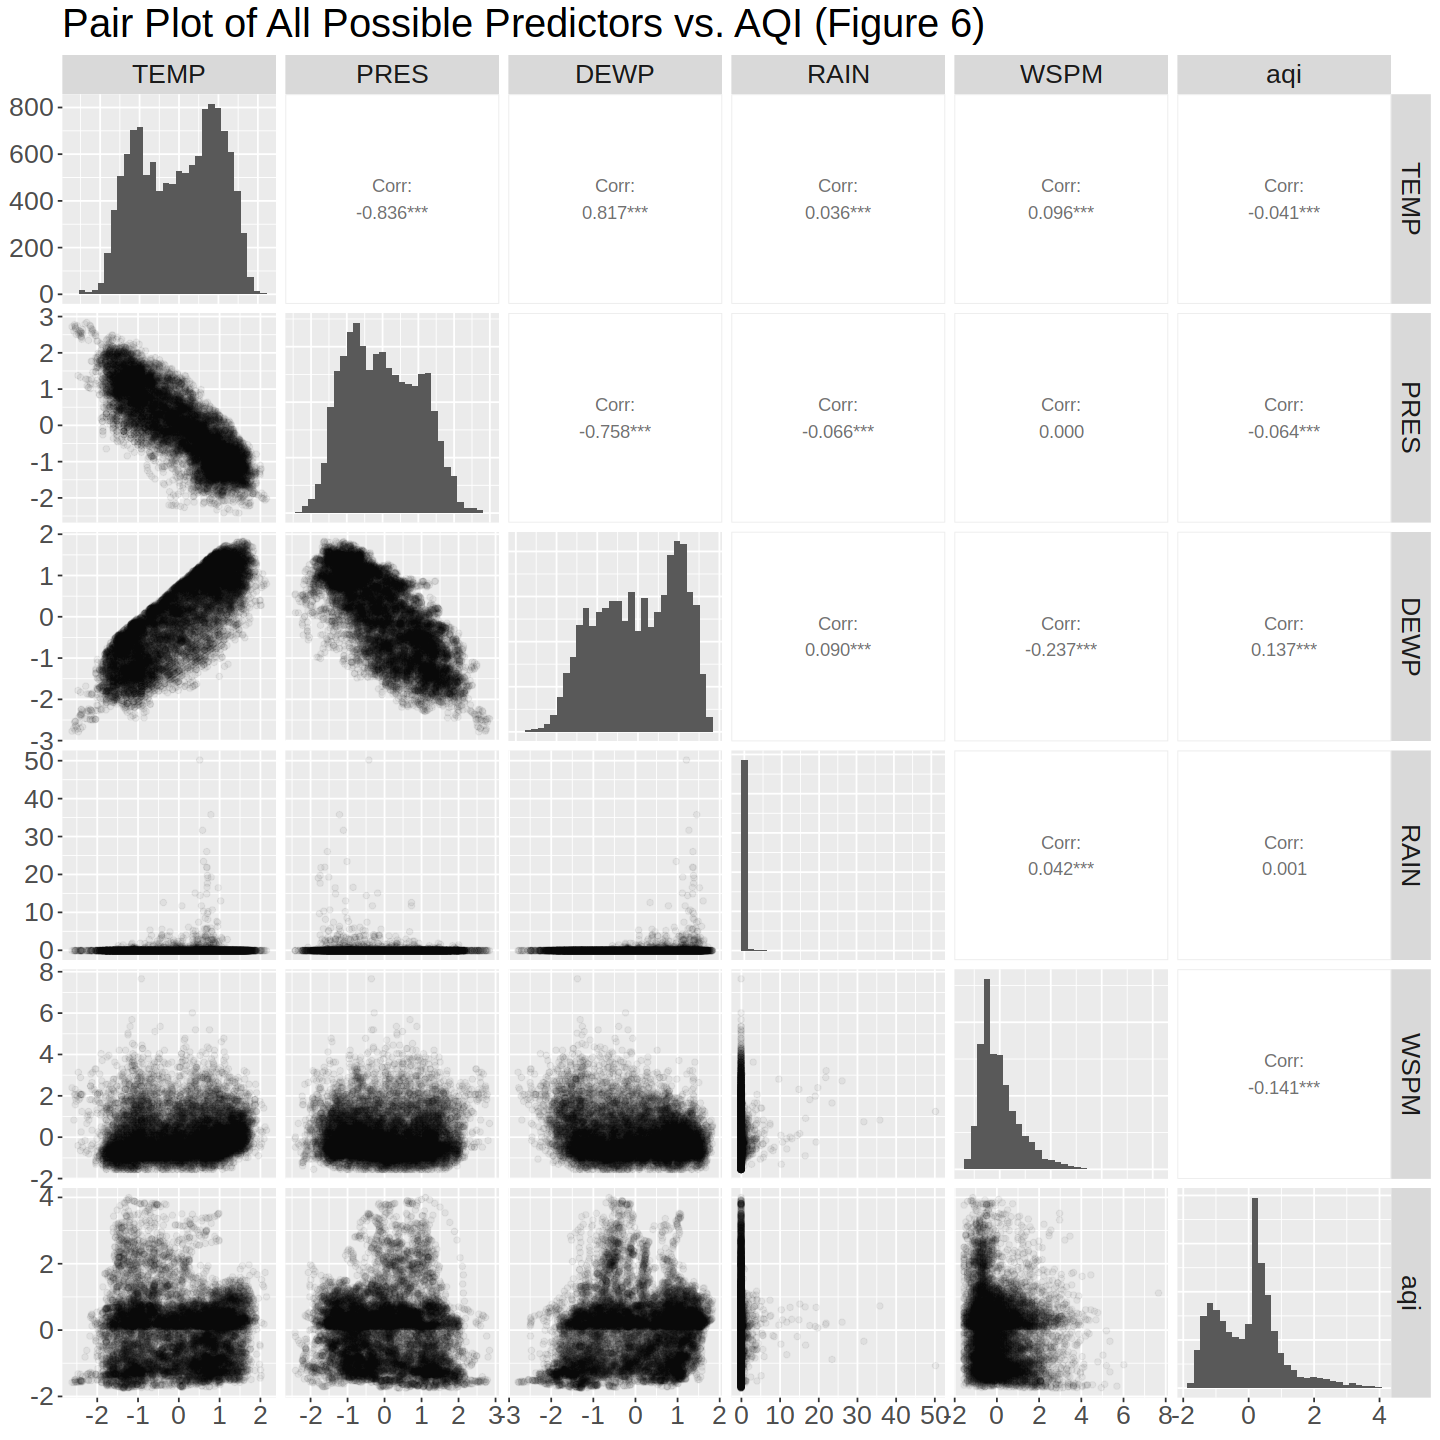

In [9]:
options(repr.plot.width = 12, repr.plot.height = 12)
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, aqi) |>
    scale() |>
    as.data.frame()

ggpairs(aqd_pairplot,
        title = "Pair Plot of All Possible Predictors vs. AQI (Figure 6)",
        lower = list(continuous = wrap('points', alpha = 0.05)),
        diag = list(continuous = "barDiag")) +
        theme(text = element_text(size = 20))

The TEMP and DEWP predictors show multicollinearity. When two predictors are strongly correlated with each other, both have a  similar impact on the overall model. This means is it not advised to use both in the final model, to avoid the effects of multicollinearity. TEMP and DEWP have a correlation coefficient of 0.834, and we deem this high enough to see fit to include only one in the final model: in this case, DEWP. We chose to use DEWP instead of TEMP because the relevant research shows that DEWP has a more consistent relationship with the levels of pollutants than TEMP[$^{12}$]( https://doi.org/10.1155/2017/3514743). DEWP and PRES also show some relationship, but we decided the slightly lower correlation made it possible to include both in the model. 
Also, judging by the pair plot above, rain has almost no correlation with AQI (correlation coefficient of <0.01) and thus was not used in the model. We ultimately decided to use PRES, DEWP and WSPM as our predictors.

We trained a multivariate linear regression model to predict AQI based on weather conditions. Our reasons for choosing this method were outlined in the [proposal](https://github.com/DonkeyBlaster/dsci-100-2023w1-group43/blob/main/Proposal.ipynb).

In [10]:
# Create model, recipe, workflow, and show fit
lm_spec <- linear_reg () |>
    set_engine("lm") |>
    set_mode("regression")
aqi_recipe <- recipe(aqi ~ PRES + DEWP + WSPM, data = aqd_train)
aqi_fit <- workflow() |>
    add_model(lm_spec) |>
    add_recipe(aqi_recipe) |>
    fit(data = aqd_train)
aqi_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         PRES         DEWP         WSPM  
  -176.1116       0.3270       0.7614      -6.0328  


Here we evaluate our model tuned using our training data by testing it against unseen data. The RMSPE is 66.74, which represents a high error considering AQI values range from 0 to 500. The multivariate linear regression model here is not sufficiently accurate. AQI is categorized into different levels and each classification bracket has a range of 50 to 100 units within the class. 66.74 is too high a value to reliably predict within the correct bracket.

In [11]:
aqi_rmspe <- aqi_fit |>
    predict(aqd_test) |>
    bind_cols(aqd_test) |>
    metrics(truth = aqi, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
aqi_rmspe

[1] 66.74037

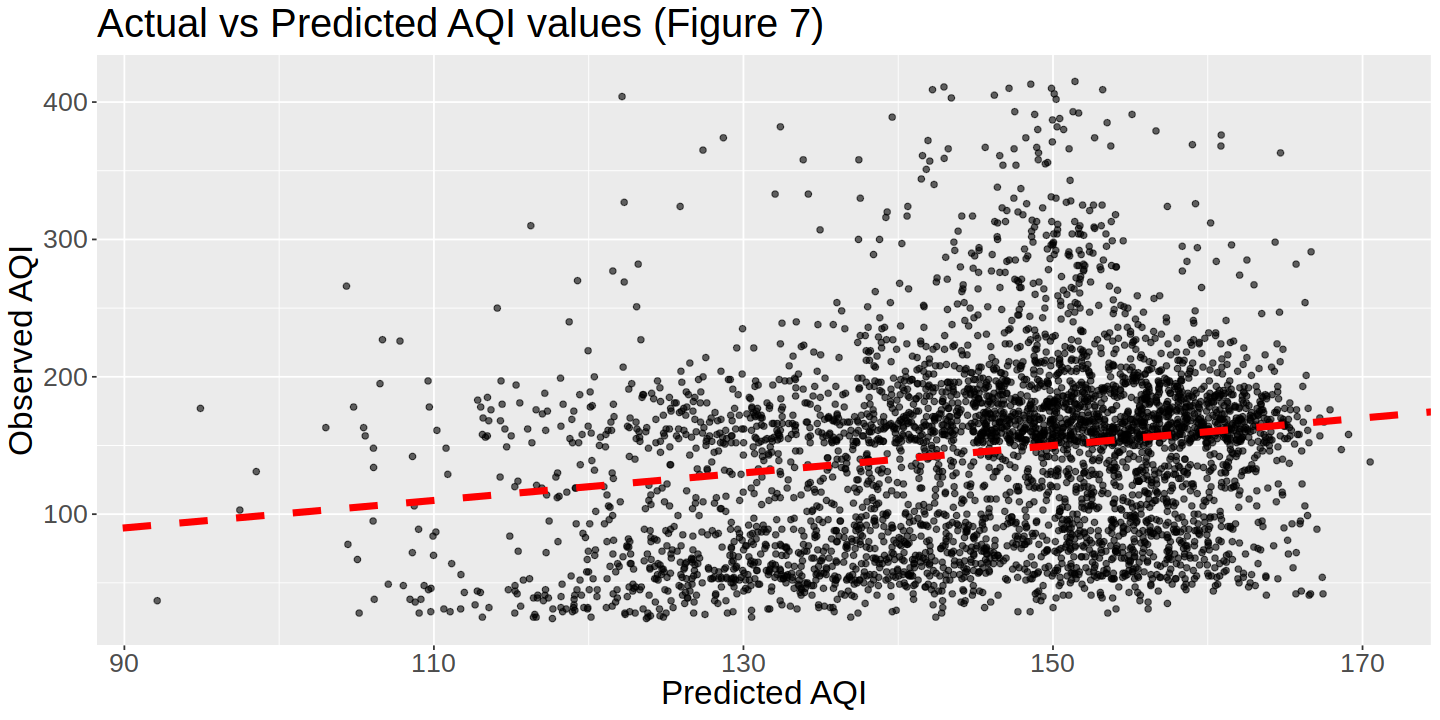

In [12]:
options(repr.plot.width = 12, repr.plot.height = 6)
aqi_predictions <- aqi_fit |>
    predict(aqd_test) |>
    bind_cols(aqd_test)
model_viz <- ggplot(aqi_predictions, aes(x = .pred, y = aqi))+
    geom_point(alpha = 0.6)+
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 2)+
    labs(title = "Actual vs Predicted AQI values (Figure 7)", x = "Predicted AQI", y = "Observed AQI")+
    theme(text = element_text(size = 20))
model_viz

Figure 7 shows observed vs predicted AQI values. If our model was 100% accurate, all points would lie along the red dashed line. This visualization of our model shows that many of our predictions are not very accurate, with quite a large spread of points. However, there does seem to be a slight clustering of points around the line, particularly for predicted values of approximately 130-165, suggesting that the model performed better in this range. In addition, it is interesting to note that the model does not predict any AQI values higher than 171, whilst the observed values range up to 415. This reveals another limitation of the model.

Because we've come to realize that our model does not predict overall AQI levels reliably, we might start investigating correlations between our predictors and individual pollutants, rather than overall AQI. We can see in the pairplot below that some pollutants (such as O3) correlate more strongly with our predictors. This means that linear regression models may be better suited to predict pollution levels for certain individual pollutants.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


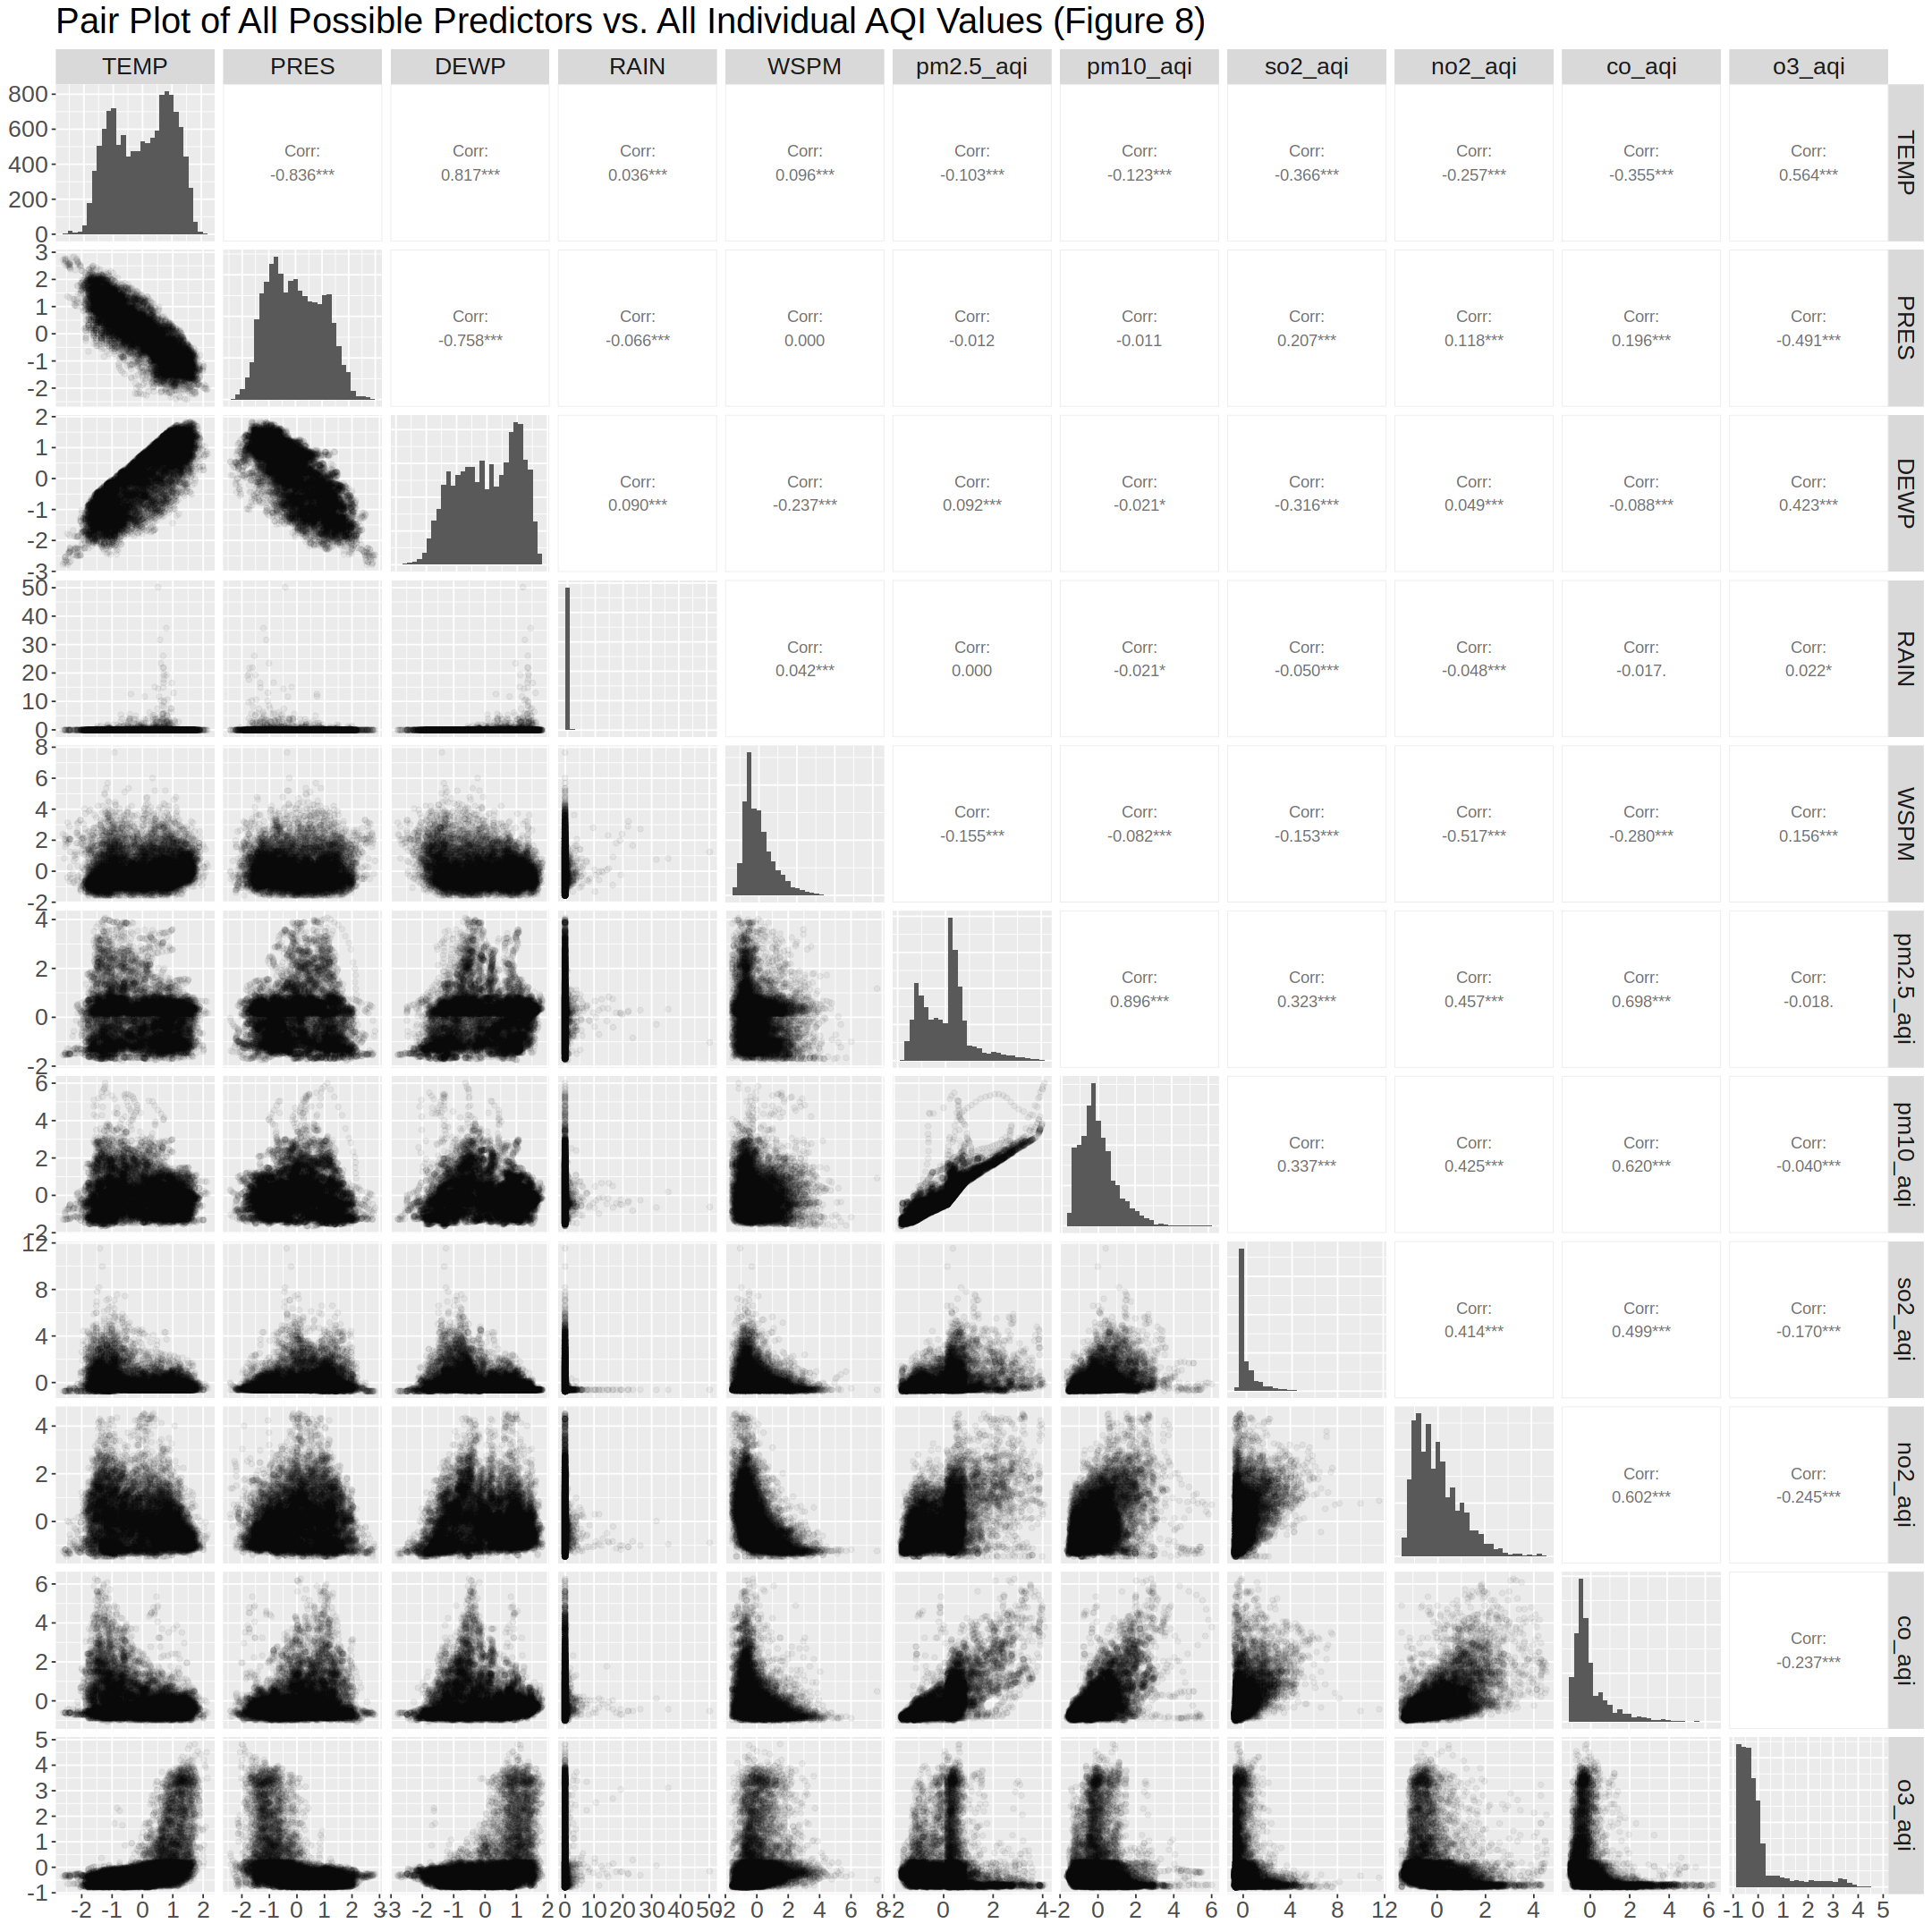

In [13]:
options(repr.plot.width = 18, repr.plot.height = 18)
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, pm2.5_aqi:o3_aqi) |>
    na.omit() |>
    scale() |>
    as.data.frame()
ggpairs(aqd_pairplot,
        title = "Pair Plot of All Possible Predictors vs. All Individual AQI Values (Figure 8)",
        lower = list(continuous = wrap('points', alpha = 0.05)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))

## Discussion

Our final model produces a regression equation of $\text{AQI} = -176.1116 + 0.3270*\text{PRES} + 0.7614*\text{DEWP} - 6.0328*\text{WSPM}$.  
If all predictor variables (dew point, pressure, wind speed) were zero, AQI would be -176.1116. This is an impossible value for AQI, as it cannot be negative, however air pressure at the Earth’s surface would never reach zero, which explains how the model can end up giving a realistic result. The coefficients of this equation mean that a 0.7614 increase in dew point temperature, a 0.3270 increase in pressure, or a 6.0328 decrease in wind speed would lead to a one unit increase in the AQI. 
The RMSPE indicates that the predicted AQI is, on average, 66.74 units away from its true value when the model is tested on data is has not seen before. In the context of our model, this represents a relatively poor prediction. AQI values can be classified to find which level of pollution is present, as shown in Figure 9.  
#### Figure 9 - AQI levels[$^1$](https://www.airnow.gov/aqi/aqi-basics/) 

<img src="https://raw.githubusercontent.com/DonkeyBlaster/dsci-100-2023w1-group43/main/aqi_levels.png"/>
 

Each AQI band is only 50 units wide, so a RMSPE of 66.74 is very poor, as this would not even predict the correct class. Ideally, the model would have a RMSPE of less than 25, as this would normally predict in the correct class (+/- 25 unit error). Should this model be improved (and RMSPE reduced), an additional step to return AQI level would make the model more user-friendly, as Figure 9 can give health recommendations based on AQI level, which is easier to interpret than the raw score.  
  
The coefficients for pressure and wind speed show the relationships that we expected to AQI, whereas dew point shows the opposite to what was expected.
The pressure coefficient shows a positive correlation with AQI, meaning an increase in air pressure causes AQI to increase (i.e. worse air quality). This relationship is explained by theory, as high-pressure systems often lead to stagnating of air, which allows pollutants to accumulate, leading to poor air quality.[$^3$](https://doi.org/10.1016/j.atmosenv.2008.03.043) The opposite is true in low pressure systems, where the weather is generally associated with higher precipitation levels and wind speeds – these both lead to pollutants being washed out of the air.[$^{14}$](https://doi.org/10.1016/j.atmosenv.2015.05.063)
The wind speed coefficient shows a negative correlation with AQI, meaning increasing wind speed decreases AQI (i.e. improves air quality). This relationship is as expected, as higher wind speeds mean there is greater movement of air, and therefore greater dispersal of pollutants, leading to improved air quality.[$^6$](https://doi.org/10.1038/s41598-020-71338-7.) When wind speed is low, mixing within the atmosphere is limited, meaning pollutants can accumulate and cause increases in AQI.
The dew point coefficient shows a positive correlation with AQI, which indicates that increasing dew point increases AQI. This relationship is not what would be expected from prior research. Dew point is the temperature at which air becomes saturated, and water droplets start to condense. Below this temperature, clouds will form, often with pollutant particles as condensation nuclei, and subsequently precipitation will remove these pollutants from the air.[$^{12}$](https://doi.org/10.1155/2017/3514743) However, this process also depends on air temperature and humidity, which may explain why the relationship seen in the final model may not be what is expected.[$^{11}$](https://doi.org/10.3390/ijerph192316119.)
Overall, our model gives us a relatively high RMSPE. There is a significant amount of published literature detailing the impacts of different weather variables on air pollution, so we would have expected the model to predict better than it did. However, there are some improvements and changes we could make in order to try and create a model with more accurate predictions, as explained below.


### Limitations and future areas for improvement
As previously mentioned, we disregarded the wind direction variable for this project, as it was not numeric. However, this could have important implications for air quality, as it will bring air masses in from different locations. In Beijing, the city is surrounded by areas with different geographies – ranging from mountainous regions to high polluting urban areas – all of which affect initial pollution levels.[$^5$]( https://doi.org/10.1098/rspa.2015.0257) Wind direction also impacts precipitation levels – moist air masses blowing in from the ocean will bring higher levels of rainfall (particularly considering the presence of monsoons in the area), which reduces air pollutants.[$^4$](https://doi.org/10.5194/acp-8-1-2008)
One way to include wind direction in the model would be to create dummy variables, which each hold a binary value of 0 or 1. We would create one fewer variables than categories (i.e. 7 variables if we used cardinal and intercardinal directions), as a zero in all 7 of these indicates the 8th category. This becomes the reference category – the effects of all other wind directions are shown relative to this one. When dummy variables are used, each wind direction has a related coefficient, which only becomes relevant when that wind direction is ‘1’. This allows the predicted AQI value to be scaled based on wind direction, which would likely lead to an improvement in the predicting power of the model. Future research may also investigate the impact of geographic and location-based predictors, such as topography, and elevation
  
Another limitation is that our dataset only includes weather variables. Whilst weather does significantly affect air quality, there are other factors that affect pollutant levels too. One of the main controls on air pollution levels in China is the use of fossil fuels, particularly in energy and transportation industries.[$^7$](ideas.repec.org/a/zib/zbnees/v3y2019i1p35-36.html) Weather can strongly influence which pollutants remain in (or are removed from) the atmosphere, but a huge part of the AQI score is reliant on which pollutants are released into the atmosphere in the first place. This was made particularly apparent during the COVID-19 pandemic, where lockdowns and their associated industry slowdowns led to notable improvements in air quality in China.[$^{11}$](https://doi.org/10.3390/ijerph192316119) These air quality changes can confidently be attributed to human factors, rather than weather. The AQI prediction model could potentially be improved by sourcing further data that allows the inclusion of a variable (or variables) that represents the human impacts on air pollution.
Furthermore, it is clear from Figure 8 that some pollutants show much stronger correlations with predictors than others. Thus, a relevant future study could create individual models to predict AQI of specific pollutants, hopefully with more accurate predictions than our combined model. Further studies could also consider other areas in China to investigate if our results are consistent across the country or specific to Beijing.

### Impacts and Conclusion

Predicting AQI allows governments and weather organizations to identify regions that may pass the threshold for unhealthy air quality, and take necessary precautions to protect the population. For Beijing, annual weather reports from 2015 to 2018 indicate that air pressure has shown a decreasing trend in 90% of weather stations; contributing to a relatively small decrease in AQI. However, average wind speed was reported to show an decrease in 69% of the stations, observed mainly in the eastern coast and Heilongjiang Province in the northeast.[$^6$](https://doi.org/10.1038/s41598-020-71338-7) Since wind speed is significantly negatively related to AQI, particular interest in rising AQI levels for these regions would allow organizations to better deal with the adverse effects of bad air quality. Doing so is of particular importance; in part, because the impact of air pollution on the average life expectancy of a population ranks 4th among the list of factors that most negatively impact human life expectancy.[$^8$](https://www.stateofglobalair.org/health/life-expectancy) Both short and long-term exposure to high levels of particulate matter can lead to conditions ranging from reduced lung function, respiratory infections and aggravated asthma, to stroke, heart disease, chronic obstructive pulmonary disease and cancer.[$^{10}$](https://www.who.int/teams/environment-climate-change-and-health/air-quality-and-health/health-impacts)  


In conclusion, our relatively high RMSPE, paired with the fact that the correlation we found between AQI and dew point opposes our expectations, suggests that there are non-trivial issues with our analysis. These may be attributed to the various limitations of the investigation as discussed above. Despite our investigation leading to subpar outcomes, our research has shown that further analysis into this topic is worth taking, and we have identified some key areas that may improve our model in future work.

## References
1. *AirNow*. (2018). Air Quality Index (AQI) Basics. https://www.airnow.gov/aqi/aqi-basics/.
1. Chen, S. (2019). Beijing Multi-Site Air-Quality Data. *UCI Machine Learning Repository.* https://doi.org/10.24432/C5RK5G.
1. Chen, Z. H., et al. (2020, Nov.). Relationship between Atmospheric Pollution Processes and Synoptic Pressure Patterns in\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Northern China. *Atmospheric Environment, 42(24),* 6078-6087.  https://doi.org/10.1016/j.atmosenv.2008.03.043.
1. Ding, A. J., et al. (2008, Jan.). Tropospheric Ozone Climatology over Beijing: Analysis of Aircraft Data from the MOZAIC\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Program. *Proceedings of the Royal Society A: Mathematical, Physical and Engineering Science, 8(1),* 1-13.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://doi.org/10.5194/acp-8-1-2008.
1. Liang, X., et al. (2015, Oct). Assessing Beijing’s PM 2.5 Pollution: Severity, Weather Impact, APEC and Winter Heating.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 471(2182),* \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://doi.org/10.1098/rspa.2015.0257. 
1. Liu, Y., et al. (2020, Sept). Exploring the Relationship between Air Pollution and Meteorological Conditions in China\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;under Environmental Governance. *Scientific Reports, 10(1),* https://doi.org/10.1038/s41598-020-71338-7.
1. Sarwar, M. T., et al. (2019). Causes and Control Measures of Urban Air Pollution in China. *Environment & Ecosystem\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Science (EES), 3(1),* 35–36, ideas.repec.org/a/zib/zbnees/v3y2019i1p35-36.html.
1. *State of Global Air.* (2023). Impact of Air Pollution on Life Expectancy.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://www.stateofglobalair.org/health/life-expectancy.
1. *USEPA.* (2018). Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index (AQI).\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf.
1. *World Health Organization.* (2023). Air quality and health.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://www.who.int/teams/environment-climate-change-and-health/air-quality-and-health/health-impacts.
1. Xu, X., et al. (2022, Dec.) Changes in Air Quality during the Period of COVID-19 in China. *International Journal of*\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Environmental Research and Public Health, 19(23),* 16119,  https://doi.org/10.3390/ijerph192316119. 
1. Xu, Y., and Zhu, X. (2017). Recognizing Dew as an Indicator and an Improver of Near-Surface Air Quality. *Advances in*\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Meteorology, 2017,* 1–9, https://doi.org/10.1155/2017/3514743. 
1. Xu, Z., et al. (2020, Aug.). Meteorological Change and Impacts on Air Pollution: Results from North China. *Journal of*\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Geophysical Research: Atmospheres, 125(16),* https://doi.org/10.1029/2020jd032423. 
1. Zhang, Y., et al. (2016, Jan.).  Impact of Synoptic Weather Patterns and Inter-Decadal Climate Variability on Air Quality\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;in the North China Plain during 1980–2013. *Atmospheric Environment, 124,* 119–128,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://doi.org/10.1016/j.atmosenv.2015.05.063.
